In [1]:
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('acs2017_census_tract_data.csv')
#df.info()
df = df.dropna()
df = df.drop('County', axis=1)
#df.info()
df[['State']] = df[['State']].apply(LabelEncoder().fit_transform)
df.info()
df.head()
#[.5 points] (1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode 
#any of the features until asked to do so later in the rubric. (2) Remove any observations that having missing data. 
#(3) Encode any string data as integers for now.(Use label encoder) (4) You have the option of keeping the "county" variable or removing
#it. Be sure to discuss why you decided to keep/remove this variable. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  int32  
 2   TotalPop          72718 non-null  int64  
 3   Men               72718 non-null  int64  
 4   Women             72718 non-null  int64  
 5   Hispanic          72718 non-null  float64
 6   White             72718 non-null  float64
 7   Black             72718 non-null  float64
 8   Native            72718 non-null  float64
 9   Asian             72718 non-null  float64
 10  Pacific           72718 non-null  float64
 11  VotingAgeCitizen  72718 non-null  int64  
 12  Income            72718 non-null  float64
 13  IncomeErr         72718 non-null  float64
 14  IncomePerCap      72718 non-null  float64
 15  IncomePerCapErr   72718 non-null  float64
 16  Poverty           72718 non-null  float6

,TractId,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,0,1845,899,946,2.4,86.3,5.2,0.0,1.2,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,0,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,0,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,0,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,0,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


We decided to drop the county variable due to the fact that the counties represent political subdivision which are subject to jerrymandering. The tractId is the preferred area identifier employed by the census bureau. 

In [2]:
#[.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for
#balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization 
#thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the 
#dataset be done for both the training and testing set? Explain.

from sklearn.model_selection import train_test_split

y = df['ChildPoverty']
X = df.drop(['ChildPoverty'], axis=1)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, test_size=0.2)
y_train = y_train.div(100)
y_train.describe()

count    58174.000000
mean         0.211452
std          0.185689
min          0.000000
25%          0.062000
50%          0.163000
75%          0.316000
max          1.000000
Name: ChildPoverty, dtype: float64

In [3]:
y_train = pd.qcut(y_train,q=4,labels=[1,2,3,4],precision=0)
y_train.value_counts()

1    14626
3    14556
4    14521
2    14471
Name: ChildPoverty, dtype: int64

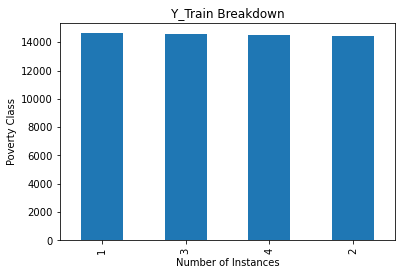

In [4]:
import matplotlib.pyplot as plt
count = y_train.value_counts()
count.plot.bar()
plt.title('Y_Train Breakdown')
plt.xlabel('Number of Instances')
plt.ylabel('Poverty Class')
plt.show()

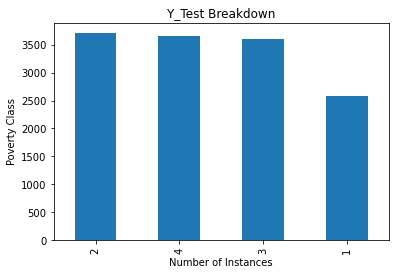

In [5]:
y_test = pd.cut(y_test, [0, 6.2, 16.3, 31.6, 100],labels=[1,2,3,4],precision=0)
y_test.value_counts()
count = y_test.value_counts()
count.plot.bar()
plt.title('Y_Test Breakdown')
plt.xlabel('Number of Instances')
plt.ylabel('Poverty Class')
plt.show()

Here we chose to use the pandas qcut to descretize the feature class into 4 equal-sized based on the sample quantiles which represent the low, medium, high, and extreme child poverty rate classes. The balancing should only be done on the training set because we want the testing set to represent never before seen data. 

In [ ]:
y_train = pd.get_dummies(y_train,prefix='ChildPoverty')
y_test = pd.get_dummies(y_test,prefix='ChildPoverty')
y_train.head()
#[.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split 
#the dataset into 80% for training and 20% for testing. There is NO NEED to split the data multiple times for this lab.
#Note: You will need to one hot encode the target, but do not one hot encode the categorical data until instructed to do so in the lab.

Here, we one-hot encoded the target training set

In [6]:
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import StandardScaler 
import numpy as np 

y_train = y_train.to_numpy(dtype='int64')
X_train = X_train.to_numpy()
y_test = y_test.to_numpy(dtype='int64')
X_test = X_test.to_numpy()

#You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions 
#of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class
#be sure that you use: (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper 
#Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose
#a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.

In [7]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(58174,)
(58174, 35)
(14544,)
(14544, 35)


We have converted all of the training and testing dataframes into numpy arrays. Notice how the number of features for the y_training set is 4 while the y_test set is only 1 feature because it represents an unknown dataset which in reality will be unbalanced. 

In [8]:
from scipy.special import expit
import sys 

class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=1,
                 C=0.0, epochs=500, eta=0.1, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot
        
    def _initialize_weights(self):
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1)
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [9]:
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost)

                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [10]:
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        V2 = (A3-Y_enc)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T

        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [11]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        

        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2

In [27]:
params = { 'n_hidden':35, 
         'C':0.1, 'epochs':20, 'eta':0.001,'minibatches':len(X_train)/18,
         'shuffle':True,'random_state':1}

In [28]:
%%time
nn_mini_batch = TLPMiniBatch(**params)

nn_mini_batch.fit(X_train, y_train, print_progress=1)
yhat = nn_mini_batch.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 20/20

Accuracy: 0.24697469746974698
CPU times: total: 41.4 s
Wall time: 19.5 s


In [29]:
%%time
nn_cross_entropy = TLPMiniBatchCrossEntropy(**params)

nn_cross_entropy.fit(X_train, y_train, print_progress=1)
yhat = nn_cross_entropy.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 20/20

Accuracy: 0.24697469746974698
CPU times: total: 43.3 s
Wall time: 20.7 s


In [30]:
%%time
nn_glorot = TLPBetterInitial(**params)

nn_glorot.fit(X_train, y_train, print_progress=1)
yhat = nn_glorot.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 20/20

Accuracy: 0.24697469746974698
CPU times: total: 45.1 s
Wall time: 22 s


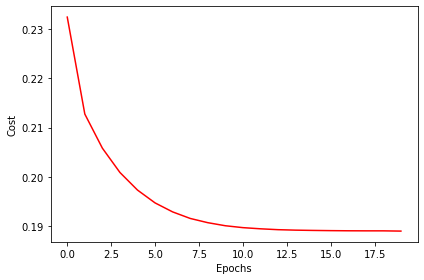

In [31]:
import matplotlib.pyplot as plt
# take the mean of each minibatch epoch
cost_avgs = [np.mean(x) for x in nn_mini_batch.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [ ]:
#[.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy.
#Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function 
#versus the number of epochs. 

In [ ]:
#[.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network 
#from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss 
#function versus the number of epochs.  

In [ ]:
#[.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the
#example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that 
#training converges by graphing the loss function versus the number of epochs. 

In [ ]:
#[1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in 
#performance? Explain, in your own words, why these models have (or do not have) different performances.  
#Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.

In [ ]:
#[1 points] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training 
#is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module
#for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.
#Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

In [ ]:
#[1 points] Repeat the previous step, adding support for a fourth layer.

In [ ]:
#[1 points] Repeat the previous step, adding support for a fifth layer. 

In [ ]:
#[2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network
#(such as AdaGrad, RMSProps, or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five
#layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it 
#is part of the exceptional work.

In [ ]:
#Exceptional Work (1 points total)
#One idea (required for 7000 level students):  Implement adaptive momentum (AdaM) in the 
#five layer neural network and quantify the performance